In [35]:
import os
import tempfile
import torch
from pathlib import Path
import json
from dataclasses import fields

from csv import writer
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.optim as optim

from data_utils.csv_dataloader import create_csv_flowpic_loader
from models.configurable_cnn import ConfigurableCNN
from training.trainer import train_model
from training.utils import set_seed, save_config_to_json
from config import Config

#### Batch normalize an existing model

In [47]:
def config_from_dict(cfg_dict):
    allowed_fields = {f.name for f in fields(Config) if f.init}
    cfg_args = {k: v for k, v in cfg_dict.items() if k in allowed_fields}
    return Config(**cfg_args)

In [54]:
exp_path = Path('/home/anatbr/students/noamshakedc/da4etc/exps/measuring_domain_shift/1_to_4/')
config_path = exp_path / 'config.json'
with open(config_path, 'r') as f:
    config_dict = json.load(f)
cfg = config_from_dict(config_dict)
    

In [62]:
model = ConfigurableCNN(cfg.MODEL_PARAMS)
model.load_state_dict(torch.load(exp_path / 'weights/model_weights_epoch_20.pth'))
model = model.to(cfg.DEVICE)

/tmp/ipykernel_670770/3809115204.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(exp_path / 'weights/model_weights_epoch_20.pth'))


In [63]:
def get_df_from_csvs(domain_idx, chunk_start, chunk_end, label_whitelist):
    dfs = []
    for i in range(chunk_start, chunk_end):
        chunk_path = os.path.join('data', 'allot_small_csvs', f'chunks_domain_{domain_idx}', f'chunk_{i:03}.csv')
        df = pd.read_csv(chunk_path)
        df = df[df['appId'].isin(label_whitelist)]
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

label_whitelist = [386,  497,  998,  171,  485, 2613,  340,  373,  561,  967,  436, 1088,
        961,  682,  521,  964, 1450, 1448,  965, 42][:4]
apps_id_df = pd.read_csv('data/app_id_mapping.csv', index_col=0)
apps_id_df = apps_id_df[apps_id_df.index.isin(label_whitelist)]
label_mapping = {row['names']: i for i, row in apps_id_df.reset_index().iterrows()}
label_indices_mapping = {label_index: new_label_index for
                         new_label_index, (label_index, row)
                         in enumerate(apps_id_df.iterrows())
                         if label_index in label_whitelist}


test_df_domain_4 = get_df_from_csvs(4, 70, 100, label_whitelist)
test_loader = create_csv_flowpic_loader([test_df_domain_4], batch_size=cfg.BATCH_SIZE, num_workers=0,
                                        shuffle=True, resolution=cfg.RESOLUTION,
                                        label_mapping=label_indices_mapping, log_t_axis=False) 


100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


In [65]:
from training.trainer import batch_norm_adaptation, validate

val_loss, val_acc, all_labels, all_predictions = validate(model, test_loader, nn.CrossEntropyLoss(), 'cuda')


In [67]:
batch_norm_adaptation(model, test_loader, device='cuda')

In [68]:
val_loss_new, val_acc_new, all_labels_new, all_predictions_new = validate(model, test_loader, nn.CrossEntropyLoss(), 'cuda')

In [69]:
print(f'Validation loss before adaptation: {val_loss}, after adaptation: {val_loss_new}')
print(f'Validation accuracy before adaptation: {val_acc}, after adaptation: {val_acc_new}')

Validation loss before adaptation: 0.35556050886061735, after adaptation: 0.35901972760221257
Validation accuracy before adaptation: 91.8362426463497, after adaptation: 91.8362426463497


#### Measuring class distribution shift

In [34]:
def get_df_from_csvs(domain_idx, chunk_start, chunk_end, label_whitelist=None):
    dfs = []
    for i in range(chunk_start, chunk_end):
        chunk_path = os.path.join('data', 'allot_small_csvs', f'chunks_domain_{domain_idx}', f'chunk_{i:03}.csv')
        df = pd.read_csv(chunk_path)
        if label_whitelist is not None:
            df = df[df['appId'].isin(label_whitelist)]
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [60]:
label_whitelist = [386,  497,  998,  171,  485, 2613,  340,  373,  561,  967,  436, 1088,
        961,  682,  521,  964, 1450, 1448,  965, 42][:10]

train_df_domain_1 = get_df_from_csvs(1, 0, 70, label_whitelist)
train_df_domain_2 = get_df_from_csvs(2, 0, 70, label_whitelist)
train_df_domain_3 = get_df_from_csvs(3, 0, 70, label_whitelist)
train_df_domain_4 = get_df_from_csvs(4, 0, 70, label_whitelist)

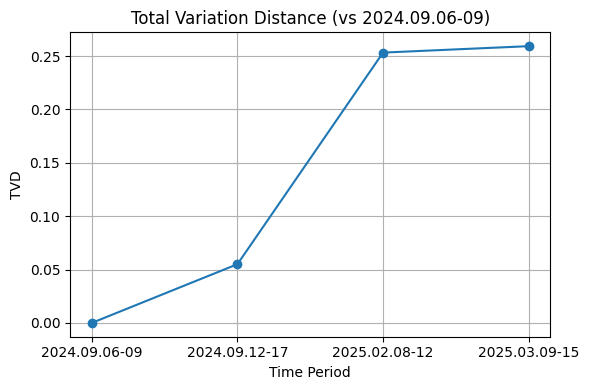

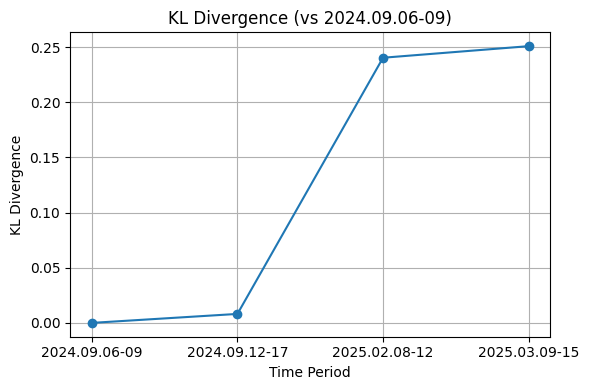

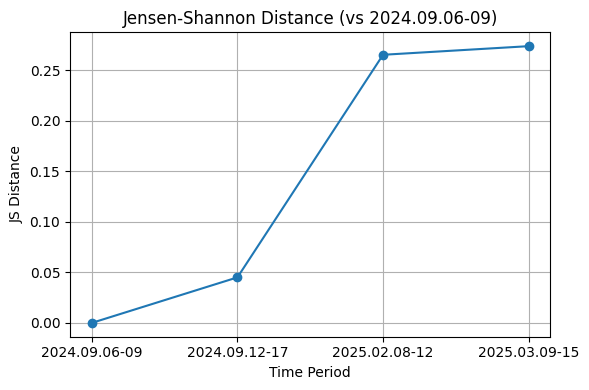

In [61]:
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

def compare_class_distributions(df1, df2, column='appId'):
    """
    Compare the class distribution of a specific column between two DataFrames.
    Returns TVD, KL, JSD.
    """
    dist1 = df1[column].value_counts(normalize=True).sort_index()
    dist2 = df2[column].value_counts(normalize=True).sort_index()

    all_keys = sorted(set(dist1.index).union(dist2.index))
    dist1 = dist1.reindex(all_keys, fill_value=0)
    dist2 = dist2.reindex(all_keys, fill_value=0)

    epsilon = 1e-10
    dist1_safe = dist1 + epsilon
    dist2_safe = dist2 + epsilon

    tvd = 0.5 * sum(abs(dist1 - dist2))
    kl_div = sum(distance.rel_entr(dist1_safe, dist2_safe))
    jsd = distance.jensenshannon(dist1, dist2)

    return tvd, kl_div, jsd

# Input DataFrames
domains = [train_df_domain_1, train_df_domain_2, train_df_domain_3, train_df_domain_4]
times = ['2024.09.06-09', '2024.09.12-17', '2025.02.08-12', '2025.03.09-15']

# Collect distance values
tvd_list, kl_list, jsd_list = [], [], []
for df in domains:
    tvd, kl, jsd = compare_class_distributions(df, train_df_domain_1, column='appId')
    tvd_list.append(tvd)
    kl_list.append(kl)
    jsd_list.append(jsd)

# --- Plot TVD ---
plt.figure(figsize=(6, 4))
plt.plot(times, tvd_list, marker='o')
plt.title('Total Variation Distance (vs 2024.09.06-09)')
plt.xlabel('Time Period')
plt.ylabel('TVD')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot KL Divergence ---
plt.figure(figsize=(6, 4))
plt.plot(times, kl_list, marker='o')
plt.title('KL Divergence (vs 2024.09.06-09)')
plt.xlabel('Time Period')
plt.ylabel('KL Divergence')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Jensen-Shannon Distance ---
plt.figure(figsize=(6, 4))
plt.plot(times, jsd_list, marker='o')
plt.title('Jensen-Shannon Distance (vs 2024.09.06-09)')
plt.xlabel('Time Period')
plt.ylabel('JS Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


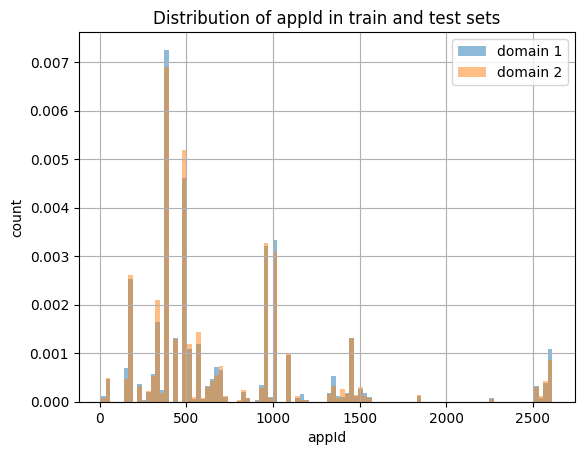

In [46]:
train_df_domain_1['appId'].hist(bins=100, alpha=0.5, label='domain 1', density=True)
train_df_domain_2['appId'].hist(bins=100, alpha=0.5, label='domain 2', density=True)
# train_df_domain_3['appId'].hist(bins=100, alpha=0.5, label='domain 3', density=True)
# train_df_domain_4['appId'].hist(bins=100, alpha=0.5, label='domain 4', density=True)
plt.legend()
plt.xlabel('appId')
plt.ylabel('count')
plt.title('Distribution of appId in train and test sets')
plt.show()

#### Validating that the app mapping is the same

In [20]:
def diff_dicts(*dicts):
    all_keys = set().union(*dicts)
    results = {}

    for key in all_keys:
        values = [d.get(key, '<Missing>') for d in dicts]
        n_results = sum(1 for v in np.unique(values) if v != '<Missing>')
        if n_results > 1:
            results[key] = values

    if results:
        print("Differences between dictionaries:")
        for key, vals in results.items():
            print(f"  Key '{key}':", end=' ')
            print(', '.join(f"dict{i+1}={val}" for i, val in enumerate(vals)))
    else:
        print("No differences found!")


In [21]:
apps_id_df = pd.read_csv('data/app_id_mapping.csv', index_col=0)
label_mapping = {row['names']: i for i, row in apps_id_df.iterrows()}


In [ ]:
mappings_path = Path('/home/anatbr/dataset/Allot/app_ids_mappings')
dicts = []
for mapping_file in mappings_path.glob('*.csv'):
    print(f"Processing {mapping_file.name}")
    current_id_df = pd.read_csv(mapping_file, index_col=0)
    current_label_mapping = {row['names']: i for i, row in current_id_df.iterrows()}
    dicts.append(current_label_mapping)

total_mapping = label_mapping
for d in dicts:
    total_mapping.update(d)

Processing ver02 - Location 01 - 2024.09.06-09_AppIds.csv
Processing ver02 - Location 01 - 2024.09.12-17_AppIds.csv
Processing ver02 - Location 01 - 2025.02.08-12_AppIds.csv
Processing ver02 - Location 01 - 2025.03.09-15_AppIds.csv
No differences found!


In [32]:
total_mapping
# Save the total mapping to a CSV file
total_mapping_df = pd.DataFrame(list(total_mapping.items()), columns=['names', 'appId'])
total_mapping_df.set_index('appId', inplace=True)
total_mapping_df.to_csv('data/app_id_mapping_1.csv')

In [ ]:
diff_dicts(*dicts, total_mapping)

No differences found!


#### Plotting results over time

In [ ]:
import matplotlib.pyplot as plt

# Data
times = ['2024.09.06-09', '2024.09.12-17', '2025.02.08-12', '2025.03.09-15']
accuracies = [97.5, 98, 94.5, 93]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(times, accuracies, marker='o', linestyle='-', linewidth=2)

# Labeling
plt.title('Accuracy per Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim([90, 100])

# Display
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Dividing csv to chunks

In [13]:
import re
def extract_numbers(x):
    if isinstance(x, str):
        # If x is a string, extract numbers
        return list(map(int, re.findall(r'\d+', x)))
    elif isinstance(x, list):
        return x
    else:
        return []    
    
lists = df['ppi-ps'].transform(extract_numbers)

In [4]:
columns = ['timeSec1970', 'timeMs', 'appId', 'ipAddrClient', 'ipAddrServer',
           'portClient', 'portServer', 'protocol', 'ppiLen', 'ppi-pdt',
           'ppi-pd', 'ppi-ps', 'ppi-paux']
n_rows_per_ds = 1e4
path = Path('/home/anatbr/dataset/Allot/ETraffic2/ver02 - Location 01 - 2025.03.09-15.csv')

ranges = []
for i in trange(200):
    df = pd.read_csv(path, nrows=n_rows_per_ds, skiprows=int(n_rows_per_ds * (i + 1)))
    df.columns = columns
    df['absoluteTime'] = pd.to_datetime(df['timeSec1970'], unit='s')
    assert df.absoluteTime.is_monotonic_increasing
    df.to_csv(f'data/allot_small_csvs/chunks_domain_4/chunk_{i:03d}.csv', index=False)
    # print(df.absoluteTime.min(), df.absoluteTime.max())
    ranges.append((df.absoluteTime.min(), df.absoluteTime.max()))

100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
